In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [31]:
def standardize_data(X, mean = None, std = None):
    x_mean, x_std = mean, std
    if mean is None:
        x_mean = X.mean()
    if std is None:
        x_std = X.std()
    x_s = (X - x_mean) / x_std
    return x_s, x_mean, x_std

In [27]:
df = pd.read_csv('date_promovare_examen.csv')
df.dropna(inplace=True)

y = df['Promovare'].values.astype(float)
x_1 = df['Ore_Studiu'].values.astype(float) # ore studiu
x_1, mean_x1, std_x1 = standardize_data(x_1)
x_2 = df['Ore_Somn'].values.astype(float) # ore somn
x_2, mean_x2, std_x2 = standardize_data(x_2)

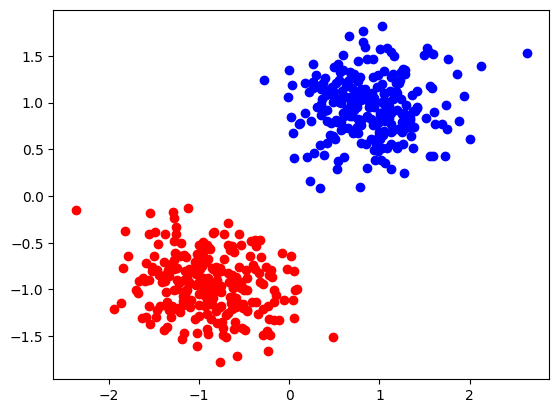

In [28]:
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(x_1[y == 1], x_2[y == 1], color='blue')
plt.scatter(x_1[y == 0], x_2[y == 0], color='red')

plt.show()

In [29]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=3)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=3)
    
    mu = alpha + beta_1 * x_1 + beta_2 * x_2
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha / beta_2 - beta_1 / beta_2 * x_1)
    
    y_data = pm.Bernoulli('y_data', p=theta, observed=y)
    trace = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_1, beta_2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.
There were 397 divergences after tuning. Increase `target_accept` or reparameterize.


In [30]:
print(az.summary(trace,var_names=['alpha', 'beta_1', 'beta_2']))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.422  1.103  -1.577    2.573      0.018    0.015    3876.0    3443.0   
beta_1  4.541  1.776   1.126    7.748      0.029    0.021    3934.0    3967.0   
beta_2  6.209  1.691   3.174    9.342      0.025    0.019    4627.0    4110.0   

        r_hat  
alpha     1.0  
beta_1    1.0  
beta_2    1.0  


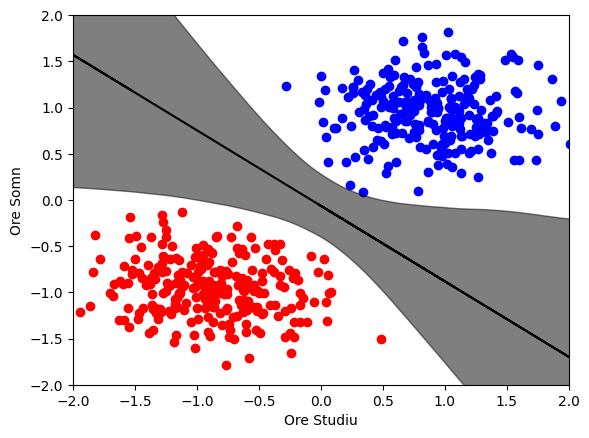

In [35]:
idx = np.argsort(y)
bd = trace.posterior['bd'].mean(("chain", "draw"))[idx]

plt.xlim(-2,2)
plt.ylim(-2,2)

plt.scatter(x_1[y == 1], x_2[y == 1], color='blue')
plt.scatter(x_1[y == 0], x_2[y == 0], color='red')

plt.plot(x_1[idx], bd, color='k')
az.plot_hdi(x_1, trace.posterior['bd'], color='k')

plt.xlabel('Ore Studiu')
plt.ylabel('Ore Somn')

plt.show()